In [1]:
import os, sys
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
sys.path.insert(0, './s2spy')
import s2spy
from s2spy import RGDR
from xeofs.xarray import EOF, Rotator
import utils, plotting
path_obs_data = '~/data/volume_2/observational/'
path_subseasonal_data = '/data/volume_2/subseasonal/'

In [2]:
target = xr.open_dataarray(os.path.join(path_obs_data, 'preprocessed', 'chrips_tp_1981-2021_africa_aggregated_intervals.nc'))
target

<xarray.DataArray 'precip' (anchor_year: 41, target_period: 10, latitude: 79,
                            longitude: 72)>
[2332080 values with dtype=float32]
Coordinates:
  * anchor_year    (anchor_year) int64 1981 1982 1983 1984 ... 2019 2020 2021
  * target_period  (target_period) int64 0 1 2 3 4 5 6 7 8 9
  * longitude      (longitude) float64 33.12 33.38 33.62 ... 50.38 50.62 50.88
  * latitude       (latitude) float64 -4.625 -4.375 -4.125 ... 14.38 14.62 14.88
    target         bool ...

In [3]:
hoa_mask = xr.open_dataarray(os.path.join(path_obs_data, 'chirps_hoa_dry_mask_0.25deg.nc'))
target_timeseries = target.where(hoa_mask).mean(dim=('latitude', 'longitude'))

## Get prediciton 4-week intervals, needed to align precursor field at specific lead-time:

In [4]:
dfs = pd.read_hdf('~/data/volume_2/subseasonal/ecmwf/aggregated/aggregation_timestamps.h5').sort_index()
df = dfs[['aggregation_start_inclusive', 'aggregation_end_inclusive']].copy()
# get 4-week periods that fall within the October, November, December months
sel_months = [10, 11, 12]
mon_start_mask = [True if m in sel_months else False for m in df.set_index('aggregation_start_inclusive').index.month]
mon_end_mask = [True if m in sel_months else False for m in df.set_index('aggregation_end_inclusive').index.month]
mon_mask = np.logical_and(mon_start_mask, mon_end_mask)
df_sub = dfs[mon_mask][dfs[mon_mask].index.year==dfs[mon_mask].index.year[0]]
# extract initialization data -1 day (because we need historic data)
anchor_dates = [(d.month, d.day) for d in df_sub.index - pd.Timedelta('1d')] 

## Start with prediction first interval:

In [5]:
index = 0
anchor_date = anchor_dates[index]
target_1d = target_timeseries.sel(target_period=index)
print(f'Prediction can be releasd on {anchor_date[0], anchor_date[1]+1}')
print(f'Precipitation target period:')
print(df_sub.iloc[0]['aggregation_start_inclusive'])
print(df_sub.iloc[0]['aggregation_end_inclusive'])


Prediction can be releasd on (9, 17)
Precipitation target period:
2000-10-02 00:00:00
2000-10-29 00:00:00


## Resample precursor data

In [6]:
# create Advent (backwards) calendar, aligned right on anchor_date
cal = s2spy.time.AdventCalendar(anchor=anchor_date, freq='30d')
cal = cal.map_years(1981, 2021)

sst = xr.open_dataarray(os.path.join(path_obs_data, 'preprocessed', 'era5_sst_1959-2021_1_12_daily_2.0deg.nc'))
sst_resampled = s2spy.time.resample(cal, sst)

z200 = xr.open_dataarray(os.path.join(path_obs_data, 'preprocessed', 'era5_z_200hpa_1959-2021_1_12_daily_2.0deg.nc'))
z200_resampled = s2spy.time.resample(cal, z200)

## Develop function to loop over dimensionality reductions

In [7]:
def pipeline_dimred(X_train, y, dimred_list = [RGDR()]):
    
    if type(X_train) is not list:
        X_train = [X_train]
    assert len(X_train) == len(dimred_list), ('# of dimensionality reduction methods in dimred_list '
                                              'is unequal to the xr.DataArrays you want to reduce')
    
    for i, X_ in enumerate(X_train):
        dimred = dimred_list[i]
        if type(dimred) is type(RGDR()):
            # fit precursor field vs y for RGDR method
            dimred.fit(X_, y)
        else: # assuming EOF-like dimred from eofs package
            model = dimred(X_, dim=['anchor_year'], weights='coslat', n_modes=2)
            model.solve()
            dimred_list[i] = model # replace unitialized EOF-like class with fitted instance
            
    return dimred_list


## Develop function to merge all reduced features

In [11]:
def merge_features(X, dimred_list = [RGDR()]):
    
    if type(X) is not list:
        X = [X]
    assert len(X) == len(dimred_list), ('# of dimensionality reduction methods in dimred_list '
                                              'is unequal to the xr.DataArrays you want to reduce')
    features_list = []
    for i, X_ in enumerate(X):
        dimred = dimred_list[i]
        if type(dimred) is type(RGDR()):
            # fit precursor field vs y for RGDR method
            features = dimred.transform(X_)
            # give common dimension name to stack features
            features = features.rename({'cluster_labels':'feature'})
            # transform dimensions into shape (samples, features)
            features = features.transpose("anchor_year", "feature")            
        else: # assuming EOF-like dimred from eofs package
            features = dimred.project_onto_eofs(X_)
            features = features.rename({'mode':'feature'})

        # clear features
        empty_coords = [k for k in features.coords.keys() if k not in ['anchor_year', 'feature']]
        if len(empty_coords) != 0:
            for c in empty_coords:
                    features = features.drop(c)
        features_list.append(features)
    return xr.concat(features_list, dim='feature')



## Set up experiment:

In [17]:
# define X
lags = np.arange(1,3)
X = [sst_resampled['sst'].sel(i_interval=lags), 
     z200_resampled['z'].sel(i_interval=lags),
     z200_resampled['z'].sel(i_interval=lags).mean(dim='i_interval')] 

dimred_list = [RGDR(), RGDR(), EOF]

# Hyperparameters for the boosting machine
params = {"n_estimators": 500,
          "max_depth": 4,
          "min_samples_split": 5,
          "learning_rate": 0.01,
          "loss": "squared_error",
          }
from sklearn import ensemble
regressor = ensemble.GradientBoostingRegressor(**params)

The mean squared error (MSE): 0.00


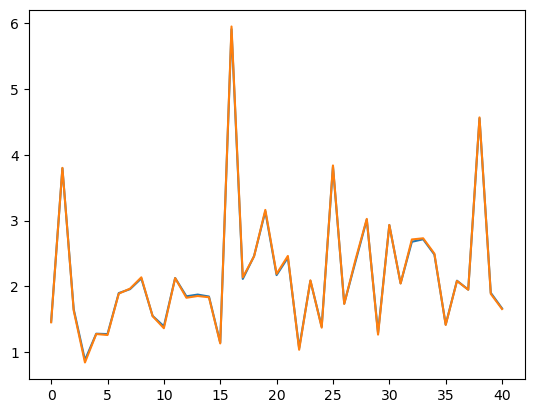

In [18]:
# loop over train-test splits still needs to be implemented
X_train = X
y = target_1d

# fit dimred methods
dimred_list = pipeline_dimred(X_train,
                              target_1d,
                              dimred_list = dimred_list)
# merge features
features = merge_features(X_train, dimred_list)

# fit model
regressor.fit(features, target_1d)
# score for testing
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(target_1d, regressor.predict(features))
print("The mean squared error (MSE): {:.2f}".format(mse))
fig, ax = plt.subplots()
ax.plot(regressor.predict(features))
ax.plot(target_1d)

In [ ]:
# for period in target_timeseries.target_period.values[::4]:
#     rg = s2spy.rgdr.rgdr.RGDR(eps_km=600, alpha=0.05, min_area_km2=3000**2)
#     rg.plot_clusters(var_resampled[var].sel(i_interval=1), target_timeseries.sel(target_period=int(period)))